
### Data Loading and Channel Selection Comparison

This analysis compares two different channel selection methods:
- **CSP-based channel selection:** Uses a common spatial pattern approach for creating virtual channels.
- **Subset-based channel selection:** Selects a direct subset of channels.

The data arrays are loaded from `.npy` files using `np.load`. Each array contains decoding results with fields for time windows, mean accuracies, and standard errors. After preprocessing the resulting curves for each channel selection method are compared and tested for significant differences.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import os
from scipy.stats import norm

wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
analysis_dir = join(data_dir, "analysis")
alpha_dir = join(analysis_dir, "alpha")
decoding_results_dir = join(alpha_dir, "decoding_results") 
plots_dir = join(alpha_dir, "plots")

In [3]:

n_comp = n_channels = 6
task = 'covert'
subset_curve = join(decoding_results_dir, f"{task}_lda_alpha_{n_comp}-comp_CSP_decC_results.npy")
csp_curve = join(decoding_results_dir, f'{task}_lda_alpha_{n_channels}-ch_subset_decC_results.npy')

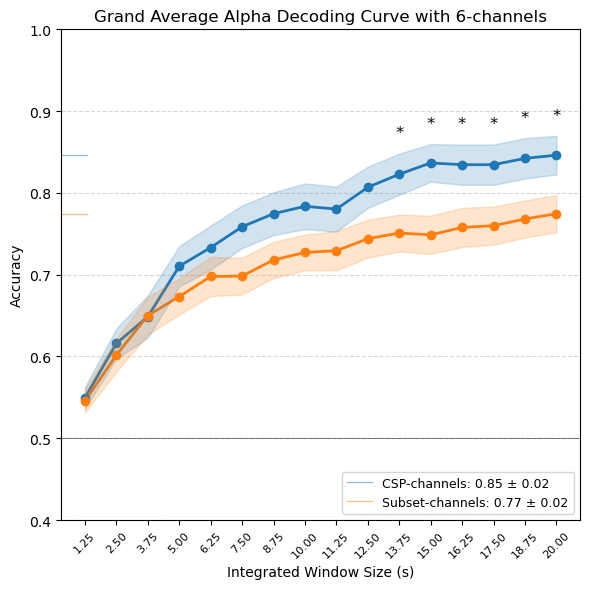

In [7]:
results_array1 = np.load(subset_curve, allow_pickle=True)
results_array2 = np.load(csp_curve, allow_pickle=True)

# Function to preprocess each array
def preprocess(results_array):
    # Extract data from the structured array
    time_windows    = results_array['time_window']
    mean_accuracies = results_array['mean_accuracy']
    mean_ses        = results_array['standard_error']
    
    # Sort by time_window
    sort_idx = np.argsort(time_windows)
    time_windows    = time_windows[sort_idx] / 120   # convert samples > milliseconds
    mean_accuracies = mean_accuracies[sort_idx]
    mean_ses        = mean_ses[sort_idx]
    
    return time_windows, mean_accuracies, mean_ses

# Preprocess both arrays
time_windows1, mean_accuracies1, mean_ses1 = preprocess(results_array1)
time_windows2, mean_accuracies2, mean_ses2 = preprocess(results_array2)

# Define inter-stimulus interval
isi = 30

# Compute x-values (integrated window size)
x_values1 = time_windows1 * isi  
x_values2 = time_windows2 * isi  

# Create the figure
plt.figure(figsize=(6, 6))

# Plot first curve (blue/ CSP)
plt.plot(x_values1, mean_accuracies1, color='tab:blue', lw=2, label='')
plt.scatter(x_values1, mean_accuracies1, color='tab:blue', zorder=3)
plt.fill_between(x_values1, 
                 mean_accuracies1 - mean_ses1, 
                 mean_accuracies1 + mean_ses1, 
                 color='tab:blue', alpha=0.2, zorder=3)

# Plot second curve (orange/ subset)
plt.plot(x_values2, mean_accuracies2, color='tab:orange', lw=2, label='')
plt.scatter(x_values2, mean_accuracies2, color='tab:orange', zorder=3)
plt.fill_between(x_values2, 
                 mean_accuracies2 - mean_ses2, 
                 mean_accuracies2 + mean_ses2, 
                 color='tab:orange', alpha=0.2, zorder=3)

# Statistical testing using a z-test at each x-axis value:
# Compute the z-values and corresponding p-values
z_values = (mean_accuracies1 - mean_accuracies2) / np.sqrt(mean_ses1**2 + mean_ses2**2)
p_values = 2* norm.sf(np.abs(z_values))  # one-tailed p-values; 2*norm.sf(..) for two-tailed

# Mark significant differences (p < 0.05) with a star
for i in range(len(x_values1)):
    if p_values[i] < 0.05:
        y_top = max(mean_accuracies1[i] + mean_ses1[i], mean_accuracies2[i] + mean_ses2[i])
        plt.text(x_values1[i], y_top + 0.02, '*', fontsize=12, ha='center', color='black')

# Customize the plot
plt.title(f'Grand Average Alpha Decoding Curve with {n_channels}-channels', fontsize=12)
plt.xlabel('Integrated Window Size (s)', fontsize=10)
plt.ylabel('Accuracy', fontsize=10)
plt.ylim(0.4, 1.0)
plt.yticks(np.arange(0.4, 1.1, 0.1))
plt.xticks(x_values1, fontsize=8, rotation=45)

# Add reference horizontal lines
plt.axhline(0.5, color='k', linestyle='-', alpha=0.5, linewidth=0.7)
plt.axhline(mean_accuracies1[-1],xmin=0, xmax=0.05, color='tab:blue', linestyle='-', linewidth=0.9, 
            label=f'CSP-channels: {mean_accuracies1[-1]:.2f} ± {mean_ses1[-1]:.2f}', alpha=0.5)
plt.axhline(mean_accuracies2[-1],xmin=0, xmax=0.05, color='tab:orange', linestyle='-', linewidth=0.9, 
            label=f'Subset-channels: {mean_accuracies2[-1]:.2f} ± {mean_ses2[-1]:.2f}', alpha=0.5)

# Add legend and grid
plt.legend(fontsize=9, loc='lower right')
plt.grid(alpha=0.5, linestyle='--', axis='y')
plt.tight_layout()

# Save the plot
filename_png = join(plots_dir, f'{task}_lda_alpha_{n_channels}-channel_arena_decC_results.png')
filename_svg = join(plots_dir, f'{task}_lda_alpha_{n_channels}-channel_arena_decC_results.svg')

plt.savefig(filename_png, dpi=300)
plt.savefig(filename_svg, dpi=300)
plt.show()
